# Macro

### Morans I
使用 Incremental Spatial Autocorrelation (ISA)

In [63]:
import numpy as np
import pandas as pd
from esda import Moran
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from libpysal.weights import DistanceBand
from scipy.spatial import distance_matrix

dataA1 = pd.read_csv('../ComputedData/Accident/DataA1_with_MRT_Youbike_Parkinglot.csv')
dataA2 = pd.read_csv('../ComputedData/Accident/DataA2_with_MRT_Youbike_Parkinglot.csv')
taiwan = gpd.read_file('../Data/OFiles_9e222fea-bafb-4436-9b17-10921abc6ef2/TOWN_MOI_1140318.shp')
taiwan = taiwan[(~taiwan['TOWNNAME'].isin(['旗津區', '頭城鎮', '蘭嶼鄉', '綠島鄉', '琉球鄉'])) & 
                (~taiwan['COUNTYNAME'].isin(['金門縣', '連江縣', '澎湖縣']))]

In [64]:
filtered_A2 = dataA2[dataA2['當事者順位'] == 1]
# filtered_A2 = filtered_A2[filtered_A2['發生月份'] == 1]
print(filtered_A2.shape)

(317023, 54)


In [65]:
gdf_points = gpd.GeoDataFrame(
    filtered_A2,
    geometry=gpd.points_from_xy(filtered_A2['經度'], filtered_A2['緯度']),
    crs='EPSG:4326'  # WGS84
)

taiwan = taiwan.to_crs(epsg=3826)
gdf_points = gdf_points.to_crs(epsg=3826)

for county, county_polygon in taiwan.groupby('COUNTYNAME'):
    print(f"處理: {county}")

    points_with_county = gpd.sjoin(gdf_points, taiwan, how='inner', predicate='within')
    accident_counts = points_with_county.groupby('COUNTYNAME').size().reset_index(name='num_accidents')
    taiwan_with_accidents = taiwan.merge(accident_counts, on='COUNTYNAME', how='left')
    taiwan_with_accidents['num_accidents'] = taiwan_with_accidents['num_accidents'].fillna(0).astype(int)


處理: 南投縣
處理: 嘉義市
處理: 嘉義縣
處理: 基隆市
處理: 宜蘭縣
處理: 屏東縣
處理: 彰化縣
處理: 新北市
處理: 新竹市
處理: 新竹縣
處理: 桃園市
處理: 臺中市
處理: 臺北市
處理: 臺南市
處理: 臺東縣
處理: 花蓮縣
處理: 苗栗縣
處理: 雲林縣
處理: 高雄市


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))

# 畫 Choropleth map
taiwan_with_accidents.plot(
    column='num_accidents',      # 用 num_accidents 當作色階依據
    cmap='OrRd',                  # OrRd = 橘紅色系
    legend=True,                  # 加上色階圖例
    edgecolor='black',             # 邊界線黑色
    linewidth=0.5,                 # 邊界線寬
    ax=ax
)

plt.title('Accident', fontsize=18)
plt.axis('off')  # 不要座標軸
plt.show()


In [131]:
from utils import incremental_spatial_autocorrelation

thresholds, moran_I, z_scores, p_values = incremental_spatial_autocorrelation(
    taiwan_with_accidents, 
    value_col='num_accidents',
    min_dist=5000,  # 設一個適合縣市之間距離的起始
    max_dist=30000,  # 台灣縣市範圍較大，最大設大一點
    step=5000  # 每次增加 10 km
)

Processing threshold: 5000 meters
8.902101139097025
Processing threshold: 10000 meters
19.374422092422165
Processing threshold: 15000 meters
24.855137358367166
Processing threshold: 20000 meters
27.553847924598394
Processing threshold: 25000 meters
31.188272383811324
Processing threshold: 30000 meters
32.33263048930943


/var/folders/w2/_g9w5yys0f171q4qqm469z1h0000gn/T/ipykernel_14507/49391274.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


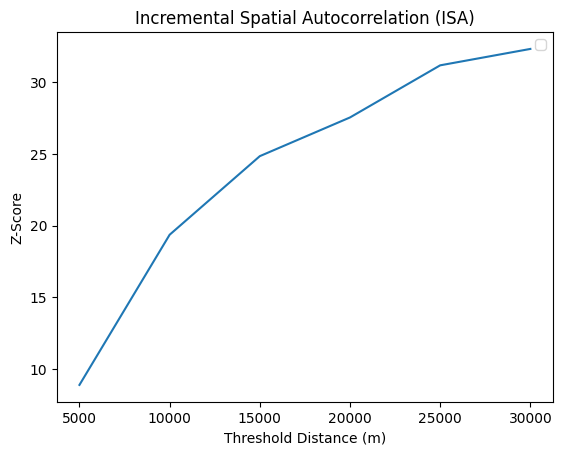

In [132]:
plt.plot(thresholds, z_scores)
plt.xlabel('Threshold Distance (m)')
plt.ylabel('Z-Score')
plt.title('Incremental Spatial Autocorrelation (ISA)')
plt.legend()
plt.show()


### GI

In [ ]:
from utils import calculate_gi

for i in range(5000, 50000, 5000):
    print(i)
    taiwan_with_accidents = calculate_gi(i, taiwan_with_accidents)
    c = taiwan_with_accidents[taiwan_with_accidents['hotspot'] != 'Not Significant']
    if c.shape[0] > 0:
        print('sig')
        print(c.shape[0])

In [128]:
taiwan_with_accidents = calculate_gi(15000, taiwan_with_accidents)

   num_accidents  GiZScore
0           2974 -1.101966
1          13308 -0.533219
2           8962 -0.679025
3          18744 -0.407652
4          18744 -0.301416


/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/esda/getisord.py:514: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/wangqiqian/opt/anaconda3/envs/ST-RTA/lib/python3.9/site-packages/esda/getisord.py:443: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 顏色對應表
cmap = mcolors.ListedColormap([
    '#800026',  # dark red - Hotspot 99%
    '#FC4E2A',  # red - Hotspot 95%
    '#FD8D3C',  # light red - Hotspot 90%
    '#d9d9d9',  # grey - Not Significant
    '#6baed6',  # light blue - Coldspot 90%
    '#3182bd',  # blue - Coldspot 95%
    '#08519c'   # dark blue - Coldspot 99%
])

categories = [
    'Hotspot 99%', 
    'Hotspot 95%', 
    'Hotspot 90%', 
    'Not Significant', 
    'Coldspot 90%', 
    'Coldspot 95%', 
    'Coldspot 99%'
]

fig, ax = plt.subplots(figsize=(12, 12))
taiwan.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)  # 畫台灣底圖

taiwan_with_accidents.plot(
    column='hotspot', 
    categorical=True, 
    cmap=cmap, 
    legend=True, 
    edgecolor='grey', 
    linewidth=0.8, 
    alpha=0.8,
    ax=ax,
    categories=categories,
    legend_kwds={
        'bbox_to_anchor': (1.05, 1),
        'loc': 'upper left',
        'frameon': False
    }
)

plt.title('Taiwan Accident Hotspot Analysis (Getis-Ord Gi*) - 90%, 95%, 99%', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()